# Úkol č. 2 - Využití neuronových sítí

  * **Deadline je 13. 5. 2024, 23:59:59**, pokud odevzdáte úkol do 20. 5. 2024, 23:59:59, budete penalizování -12 body, pozdější odevzdání je bez bodu.
  * V rámci tohoto úkolu musíte sestrojit vhodný model neuronové sítě pro vícetřídou klasifikaci.
  * Část bodů získáte za správné vypracování a část bodů získáte za výslednou přesnost Vašeho modelu na evaluačních datech.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budou strhávány body.

## Zdroj dat

 * Zdrojem dat jsou soubory `train.csv` a `evaluate.csv`.
 * Jedná se o obrázky 32x32 pixelů ve stupních šedi, které byly nějakým způsobem vyrobeny z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.
 * Soubor `evaluate.csv` obsahuje testovací data bez hodnot skutečných labelů.

## Pokyny k vypracování (max 18 bodů)

**Body zadání**, za jejichž (poctivé) vypracování získáte **18 bodů**:
  * V notebooku načtěte data ze souboru `train.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Některé obrázky také zobrazte.
  * Sestrojte a natrénujte několik variant modelu dopředné neuronové sítě. Přitom v rámci výpočetních možností:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Experimentujte s různými hloubkami a velikosmi vrstev.
      * Experimentujte se standardizací/normalizací dat.
      * Experimentujte s různými optimalizačními metodami.
      * Experimentujte s různými regularizačními technikami.
      * Získané výsledky vždy řádně okomentujte.

  * Sestrojte model konvoluční neuronové sítě. Přitom v rámci výpočetních možností:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Experimentujte s různými hloubkami a velikosmi vrstev.
      * Experimentujte se standardizací/normalizací dat.
      * Experimentujte s různými optimalizačními metodami.
      * Experimentujte s různými regularizačními technikami.
      * Získané výsledky vždy řádně okomentujte.
    
  * Ze všech zkoušených možností vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici.
  
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluate.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do sloupce **label** a identifikátory do sloupce **ID**. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
   
   * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,label
0,0
1,1
...
```

## Vyhodnocovací část (max 7 bodů)
Za přesnost (accuraccy) na odevzdaných predikcích pro vyhodnocovací množnu získáte dalších max **7 bodů**.

Označíme-li $A$ přesnost, které jste dosáhli, zaokrouhlenou na 2 desetinná místa, akumulují se výsledné body podle následujících pravidel:
* pokud $A \geq 0.80$ obdržíte +1 bod
* pokud $A \geq 0.83$ obdržíte +1 bod
* pokud $A \geq 0.86$ obdržíte +1 bod
* pokud $A \geq 0.87$ obdržíte +1 bod
* pokud $A \geq 0.88$ obdržíte +1 bod
* pokud $A \geq 0.89$ obdržíte +1 bod
* pokud $A \geq 0.90$ obdržíte +1 bod

**Příklad:** Pokud bude Vaše přesnost 0.856, vyjde A = 0.86 a vy získáte 3 body.


## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

In [1]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device("cuda:0")
    print("CUDA device set to:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU instead.")

CUDA device set to: NVIDIA GeForce RTX 3060 Ti


## Data description

We can see total 52500 data points with 1025 column, where 1024 columns are individual pixels. There is no missing values in this dataset.
Labels are more or less evenly distributed

In [3]:
train_data  = pd.read_csv('train.csv')
eval_data = pd.read_csv('evaluate.csv')

X = train_data.drop(columns=['label'])
y = train_data['label']

random_seed = 666
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.25, random_state=random_seed)
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, test_size=0.25, random_state=random_seed)
print("Train data size:", len(Xtrain))
print("Validation data size:", len(Xval))
print("Test data size:", len(Xtest))

standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

# --- standard scaling  -----
Xtrain_standard = standard_scaler.fit_transform(Xtrain)
Xtrain_standard = pd.DataFrame(Xtrain_standard, columns=Xtrain.columns)
Xval_standard = standard_scaler.transform(Xval)
Xval_standard = pd.DataFrame(Xval_standard, columns=Xval.columns)


# ---- min max scaling -------
Xtrain_min_max = min_max_scaler.fit_transform(Xtrain)
Xtrain_min_max = pd.DataFrame(Xtrain_min_max, columns=Xtrain.columns)
Xval_min_max = min_max_scaler.transform(Xval)
Xval_min_max = pd.DataFrame(Xval_min_max, columns=Xval.columns)

Train data size: 29531
Validation data size: 9844
Test data size: 13125


In [4]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52500 entries, 0 to 52499
Columns: 1025 entries, pix1 to label
dtypes: int64(1025)
memory usage: 410.6 MB
None


In [5]:
missing_values = train_data.isna().any().any()
if missing_values:
    print("There are missing values in the dataset.")
else:
    print("There are no missing values in the dataset.")

There are no missing values in the dataset.


In [6]:
print(train_data['label'].value_counts())

label
5    5300
9    5275
8    5274
3    5266
7    5258
0    5253
6    5244
4    5225
2    5222
1    5183
Name: count, dtype: int64


In [52]:
def show_image(image, label):
    plt.figure()
    plt.imshow(image.values.reshape(32, 32), cmap='gray')
    plt.title('Label: ' + str(label))
    plt.show()

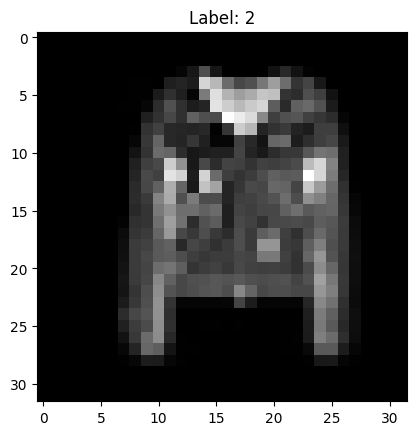

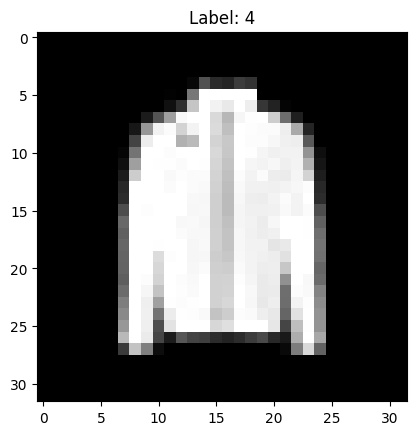

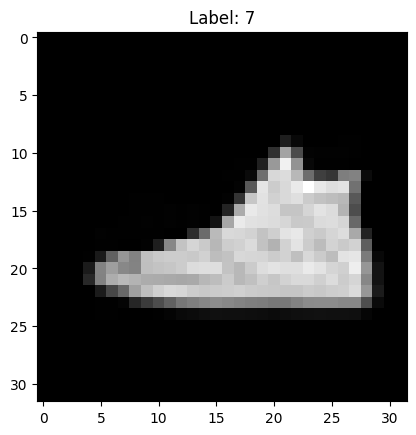

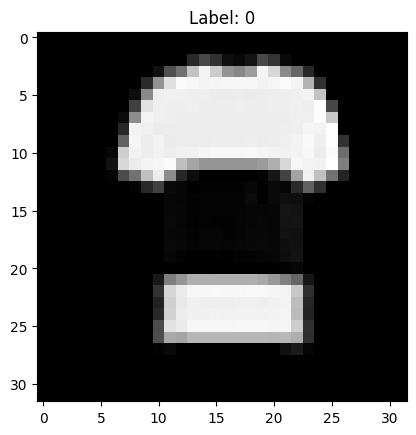

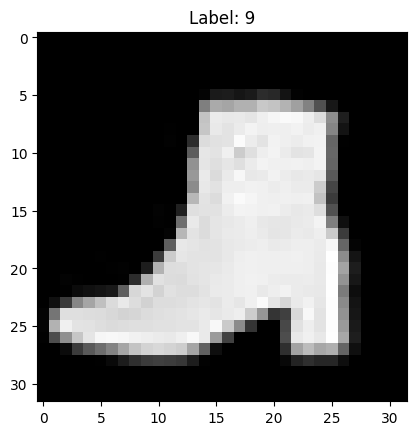

In [37]:
random_indices = train_data.sample(5).index
for index in random_indices:
    show_image(train_data.iloc[index, 0:1024], train_data.iloc[index, 1024])

Uniform Manifold Approximation and Projection (UMAP) is a technique for visualizing high-dimensional data in lower-dimensional spaces.

In our case we can see that many clusters overlap, but for example label 1 and 7 ( possibly 8, could not recognise what colour this is) has some distinct features 

<Axes: >

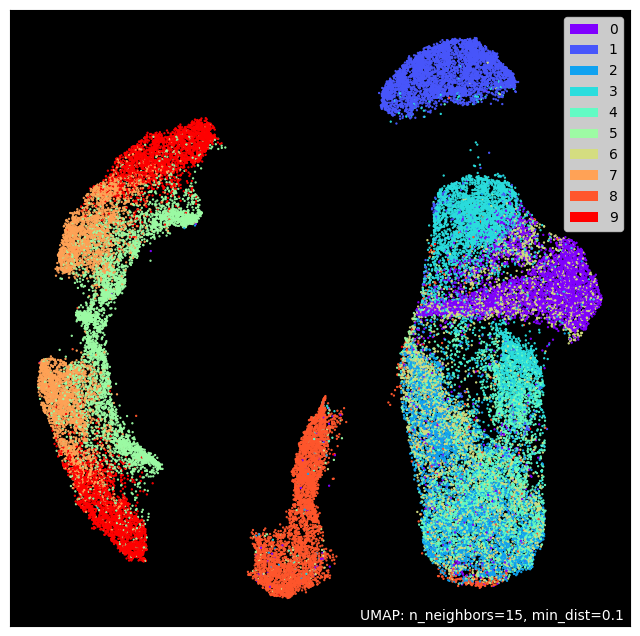

In [30]:
import umap.plot

mapper_org = umap.UMAP().fit(X)
umap.plot.points(mapper_org, labels=y, theme='fire')

### Prepare data for PyTorch

Firstly we will convert our original/standard/minmax data to tensors and then create tensors datasets. Also we will change our format to [N,C,H,W]:
* N - Number of data points
* C - channels, we have black/white so 1 channel
* H - pixels height
* W - pixels width

In [4]:
# labels
Ytrain = torch.tensor(Ytrain.values, dtype = torch.long)
Yval = torch.tensor(Yval.values, dtype = torch.long)

# train data original, minmax, standard scale
Xtrain = torch.tensor(Xtrain.values, dtype = torch.float)
Xtrain_standard = torch.tensor(Xtrain_standard.values, dtype = torch.float)
Xtrain_min_max = torch.tensor(Xtrain_min_max.values, dtype = torch.float)

Xval = torch.tensor(Xval.values, dtype = torch.float)
Xval_standard = torch.tensor(Xval_standard.values, dtype = torch.float)
Xval_min_max = torch.tensor(Xval_min_max.values, dtype = torch.float)

In [5]:
Xtrain = Xtrain.reshape(-1, 1, 32, 32)
Xtrain_standard = Xtrain_standard.reshape(-1, 1, 32, 32)
Xtrain_min_max = Xtrain_min_max.reshape(-1, 1, 32, 32)

Xval = Xval.reshape(-1, 1, 32, 32)
Xval_standard = Xval_standard.reshape(-1, 1, 32, 32)
Xval_min_max = Xval_min_max.reshape(-1, 1, 32, 32)

In [6]:
print(Xtrain.shape, Ytrain.shape)

torch.Size([29531, 1, 32, 32]) torch.Size([29531])


In [7]:
train_dataset = torch.utils.data.TensorDataset(Xtrain, Ytrain)
val_dataset = torch.utils.data.TensorDataset(Xval, Yval)

train_dataset_standard = torch.utils.data.TensorDataset(Xtrain_standard, Ytrain)
val_dataset_standard = torch.utils.data.TensorDataset(Xval_standard, Yval)

train_dataset_min_max = torch.utils.data.TensorDataset(Xtrain_min_max, Ytrain)
val_dataset_min_max = torch.utils.data.TensorDataset(Xval_min_max, Yval)

In [8]:
training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

training_loader_standard = torch.utils.data.DataLoader(train_dataset_standard, batch_size=32, shuffle=True)
validation_loader_standard = torch.utils.data.DataLoader(val_dataset_standard, batch_size=128, shuffle=False)

training_loader_minmax = torch.utils.data.DataLoader(train_dataset_min_max, batch_size=32, shuffle=True)
validation_loader_minmax = torch.utils.data.DataLoader(val_dataset_min_max, batch_size=128, shuffle=False)

We are ready to train and test our Neural Network models

## Our Basic Neural Networks classes

#### BasicNN
* 2 hidden layers  with 256 and 128 neurons
* output layer with 10 neurons, which produces the raw output logits

#### AdvancedNN
* 1 more hidden layes, in total 3 hidden layers with 512, 256, 128  neurons
* output layer with 10 neurons, which produces the raw output logits

All hidden layers are activated by RELU function. 

In [10]:
class BasicNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fco = nn.Linear(128, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fco(x)
        return x

In [11]:
class AdvancedNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fco = nn.Linear(128, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fco(x)
        return x

### Loss function 

* Cross-Entropy Loss: commonly used loss function for multi-class classification tasks. Measures the difference between the predicted probability distribution and the true probability distribution


In [12]:
loss_fn = torch.nn.CrossEntropyLoss()

Function that trains 1 epoch

In [13]:
# code taken from tutorial lesson
def train_one_epoch(model, loss_fn, optimizer, train_loader):
    running_cum_loss = 0.
    for data in train_loader:
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs = inputs.to(device) # to train on gpu
        labels = labels.to(device) # to train on gpu
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)

        # Backpropagation
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        last_mean_loss = loss.item()
        running_cum_loss += last_mean_loss * inputs.shape[0]

    # Return of the average over the whole training set
    return running_cum_loss / len(train_data)

### Training without regularization, Adam optimizer

Function bellow is a wrapper for a easier call for different models and different scaled data.

One change that I made from tutorial lesson code, that I save best accuracy and compare models with it, because it is my main goal to increase accuracy

In [14]:
def train_no_regularization(max_epochs, model, optimizer, loader, val_loader, model_path):
    best_vacc = 0
    progress_bar = tqdm(total=max_epochs, desc='Training Progress', position=0, leave=True)
    for epoch in range(max_epochs):
        # Indicate training phase
        model.train(True)
    
        # One training step
        avg_loss = train_one_epoch(model, loss_fn, optimizer, loader)
    
        # Indicate evaluation phase
        model.train(False)
    
        # Validation performance
        running_cum_vloss = 0.0
        vcorrect = 0
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device) # again to train on gpu
            vlabels = vlabels.to(device) # again to train on gpu
            with torch.no_grad():
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
            running_cum_vloss += vloss * vinputs.shape[0]
            # count the correctly classified samples
            vcorrect += (voutputs.argmax(1) == vlabels).float().sum()
        # Get average loss and accuraccy
        avg_vloss = running_cum_vloss / len(val_dataset)
        vacc = vcorrect / len(val_dataset)
    
        #progress_bar.write(f"EPOCH {epoch + 1}: TRAIN loss: {avg_loss:.3f}, VALIDATION loss: {avg_vloss:.3f}, accuracy: {vacc:.3f}")
    
        # Track best performance, and save the model's state
        if vacc > best_vacc:
            #progress_bar.write("Saving best model")
            best_vacc = vacc
            torch.save(model.state_dict(), model_path)
        progress_bar.update(1)
    progress_bar.close()
    
    return best_vacc

In order to train faster I moved all my models and data on GPU

In [15]:
tmp = BasicNN().to(device)
best_vacc_basic = train_no_regularization(30, tmp, torch.optim.Adam(tmp.parameters()), training_loader, validation_loader, "saves/best_basic.pt")

# ------------------------- Standard scaled dataset ------------------------------------
tmp = BasicNN().to(device) # reset network
best_vacc_basic_standard = train_no_regularization(30, tmp, torch.optim.Adam(tmp.parameters()), training_loader_standard, validation_loader_standard, "saves/best_basic_standard.pt")

# ------------------------- Minmax scaled dataset --------------------------------------
tmp = BasicNN().to(device) # reset network
best_vacc_basic_minmax = train_no_regularization(30, tmp, torch.optim.Adam(tmp.parameters()), training_loader_minmax, validation_loader_minmax, "saves/best_basic_minmax.pt")

Training Progress: 100%|██████████| 30/30 [01:10<00:00,  2.35s/it]


In [16]:
tmp = AdvancedNN().to(device)
best_vacc_advanced = train_no_regularization(30, tmp, torch.optim.Adam(tmp.parameters()), training_loader, validation_loader, "saves/best_advanced.pt")

# ------------------------- Standard scaled dataset ------------------------------------
tmp = AdvancedNN().to(device)
best_vacc_advanced_standard = train_no_regularization(30, tmp, torch.optim.Adam(tmp.parameters()), training_loader_standard, validation_loader_standard, "saves/best_advanced_standard.pt")

# ------------------------- Minmax scaled dataset --------------------------------------
tmp = AdvancedNN().to(device)
best_vacc_advanced_minmax = train_no_regularization(30, tmp, torch.optim.Adam(tmp.parameters()), training_loader_minmax, validation_loader_minmax, "saves/best_advanced_minmax.pt")

Training Progress: 100%|██████████| 30/30 [01:12<00:00,  2.41s/it]


In [18]:
print("TRAINING RESULTS using Adam(validation accuracy):")
print(f"Basic model:\n"
      f"Original dataset: {best_vacc_basic.item()}\n"
      f"Standard scaled dataset: {best_vacc_basic_standard.item()}\n"
      f"Minmax scaled dataset: {best_vacc_basic_minmax.item()}\n")


print(f"Advanced model\n:"
      f"Original dataset: {best_vacc_advanced.item()}\n"
      f"Standard scaled dataset: {best_vacc_advanced_standard.item()}\n"
      f"Minmax scaled dataset: {best_vacc_advanced_minmax.item()}")

TRAINING RESULTS using Adam(validation accuracy):
Basic model:
Original dataset: 0.8291345238685608
Standard scaled dataset: 0.8403088450431824
Minmax scaled dataset: 0.8462007641792297

Advanced model
:Original dataset: 0.8360422849655151
Standard scaled dataset: 0.84112149477005
Minmax scaled dataset: 0.847318172454834


### Training without regularization, RMSProp optimizer

In [19]:
tmp = BasicNN().to(device)
best_vacc_basic_rms = train_no_regularization(30, tmp, torch.optim.RMSprop(tmp.parameters()), training_loader, validation_loader, "saves/best_basic_rms.pt")

tmp = BasicNN().to(device)
best_vacc_basic_standard_rms = train_no_regularization(30, tmp, torch.optim.RMSprop(tmp.parameters()), training_loader_standard, validation_loader_standard, "saves/best_basic_standard_rms.pt")

tmp = BasicNN().to(device)
best_vacc_basic_minmax_rms = train_no_regularization(30, tmp, torch.optim.RMSprop(tmp.parameters()), training_loader_minmax, validation_loader_minmax, "saves/best_basic_minmax_rms.pt")

Training Progress: 100%|██████████| 30/30 [01:03<00:00,  2.13s/it]


In [20]:
tmp = AdvancedNN().to(device)
best_vacc_advanced_rms = train_no_regularization(30, tmp, torch.optim.RMSprop(tmp.parameters()), training_loader, validation_loader, "saves/best_advanced_rms.pt")

tmp = AdvancedNN().to(device)
best_vacc_advanced_standard_rms = train_no_regularization(30, tmp, torch.optim.RMSprop(tmp.parameters()), training_loader_standard, validation_loader_standard, "saves/best_advanced_standard_rms.pt")

tmp = AdvancedNN().to(device)
best_vacc_advanced_minmax_rms = train_no_regularization(30, tmp, torch.optim.RMSprop(tmp.parameters()), training_loader_minmax, validation_loader_minmax, "saves/best_advanced_minmax_rms.pt")

Training Progress: 100%|██████████| 30/30 [01:11<00:00,  2.39s/it]


From the results below, Adam performed better as optimizer, so we will use it instead of RMSProp with regularization. We can even see that some models have poor accuracy of 10%, 18%, 42%.

In [22]:
print("TRAINING RESULTS using RMSProp(validation accuracy):")
print(f"Basic model:\n"
      f"Original dataset: {best_vacc_basic_rms.item()}\n"
      f"Standard scaled dataset: {best_vacc_basic_standard_rms.item()}\n"
      f"Minmax scaled dataset: {best_vacc_basic_minmax_rms.item()}\n")


print(f"Advanced model:\n"
      f"Original dataset: {best_vacc_advanced_rms.item()}\n"
      f"Standard scaled dataset: {best_vacc_advanced_standard_rms.item()}\n"
      f"Minmax scaled dataset: {best_vacc_advanced_minmax_rms.item()}")

TRAINING RESULTS using RMSProp(validation accuracy):
Basic model:
Original dataset: 0.188033327460289
Standard scaled dataset: 0.6243396997451782
Minmax scaled dataset: 0.8121698498725891

Advanced model:
Original dataset: 0.10219423472881317
Standard scaled dataset: 0.42675742506980896
Minmax scaled dataset: 0.8099349737167358


### Training with L1 regularization

In [27]:
# code taken from tutorial lesson
def train_one_epoch_lreg(model, loss_fn, optimizer, train_loader , l_alpha = 0.1):
    running_cum_loss = 0.
    for data in train_loader:
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        
        # regularization
        l_reg = torch.tensor(0.)
        l_reg = l_reg.to(device)
        l_reg += torch.linalg.vector_norm(model.fco.weight.flatten(),1)
        
        loss = loss + l_alpha*l_reg
        
        # Backpropagation
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        last_mean_loss = loss.item()
        running_cum_loss += last_mean_loss * inputs.shape[0]

    # Return of the average over the whole training set
    return running_cum_loss / len(train_data)

In [26]:
def train_regularization(max_epochs, model, optimizer, loader, val_loader, model_path, best_vacc,  l_alpha):
    #best_vacc = 0
    progress_bar = tqdm(total=max_epochs, desc='Training Progress', position=0, leave=True)
    for epoch in range(max_epochs):
        # Indicate training phase
        model.train(True)

        # One training step
        avg_loss = train_one_epoch_lreg(model, loss_fn, optimizer, loader, l_alpha)

        # Indicate evaluation phase
        model.train(False)

        # Validation performance
        running_cum_vloss = 0.0
        vcorrect = 0
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            with torch.no_grad():
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
            running_cum_vloss += vloss * vinputs.shape[0]
            # count the correctly classified samples
            vcorrect += (voutputs.argmax(1) == vlabels).float().sum()
        # Get average loss and accuraccy
        avg_vloss = running_cum_vloss / len(val_dataset)
        vacc = vcorrect / len(val_dataset)

        #progress_bar.write(f"EPOCH {epoch + 1}: TRAIN loss: {avg_loss:.3f}, VALIDATION loss: {avg_vloss:.3f}, accuracy: {vacc:.3f}")

        # Track best performance, and save the model's state
        if vacc > best_vacc:
            #progress_bar.write("Saving best model")
            best_vacc = vacc
            torch.save(model.state_dict(), model_path)
        progress_bar.update(1)
    progress_bar.close()

    return best_vacc

In [28]:
best_vacc_basic_l1 = 0
best_vacc_basic_standard_l1 = 0
best_vacc_basic_minmax_l1 = 0

for alpha in [0.05, 0.1, 0.3, 0.5, 0.8, 1, 1.5, 2]:
    tmp = BasicNN().to(device)
    best_vacc_basic_l1 = train_regularization(20, tmp, torch.optim.Adam(tmp.parameters()), training_loader, validation_loader, "saves/best_basic_l1.pt", best_vacc_basic_l1, alpha)

    tmp = BasicNN().to(device)
    best_vacc_basic_standard_l1 = train_regularization(20, tmp, torch.optim.Adam(tmp.parameters()), training_loader_standard, validation_loader_standard, "saves/best_basic_standard_l1.pt", best_vacc_basic_standard_l1, alpha)
    
    tmp = BasicNN().to(device)
    best_vacc_basic_minmax_l1 = train_regularization(20, tmp, torch.optim.Adam(tmp.parameters()), training_loader_standard, validation_loader_standard, "saves/best_basic_minmax_l1.pt", best_vacc_basic_minmax_l1, alpha)

Training Progress: 100%|██████████| 20/20 [00:50<00:00,  2.54s/it]


L1 regularization did not help that much, accuracy stay the same.

In [30]:
print("TRAINING RESULTS using Adam and L1 regularization(validation accuracy):")
print(f"Basic model:\n"
      f"Original dataset: {best_vacc_basic_l1.item()}\n"
      f"Standard scaled dataset: {best_vacc_basic_standard_l1.item()}\n"
      f"Minmax scaled dataset: {best_vacc_basic_minmax_l1.item()}\n")

TRAINING RESULTS using Adam and L1 regularization(validation accuracy):
Basic model:
Original dataset: 0.839597761631012
Standard scaled dataset: 0.8340106010437012
Minmax scaled dataset: 0.8327915668487549


In [33]:
dt = {
    'Classifier': ['Basic', 'Advanced'],
    'Original (Adam)': [best_vacc_basic.item(), best_vacc_advanced.item()],
    'Standard (Adam)': [best_vacc_basic_standard.item(), best_vacc_advanced_standard.item()],
    'MinMax (Adam)': [best_vacc_basic_minmax.item(), best_vacc_advanced_minmax.item()],
    'Original (RMSProp)': [best_vacc_basic_rms.item(), best_vacc_advanced_rms.item()],
    'Standard (RMSProp)': [best_vacc_basic_standard_rms.item(), best_vacc_advanced_standard_rms.item()],
    'MinMax (RMSProp)': [best_vacc_basic_minmax_rms.item(), best_vacc_advanced_minmax_rms.item()],
    'Original + L1 (Adam)': [best_vacc_basic_l1.item(), "NaN"],
    'Standard + L1 (Adam)': [best_vacc_basic_standard_l1.item(), "NaN"],
    'MinMax + L1 (Adam)': [best_vacc_basic_minmax_l1.item(), "NaN"]
}

df = pd.DataFrame(dt)
df.set_index('Classifier', inplace=True)
print(df)

            Original (Adam)  Standard (Adam)  MinMax (Adam)  \
Classifier                                                    
Basic              0.829135         0.840309       0.846201   
Advanced           0.836042         0.841121       0.847318   

            Original (RMSProp)  Standard (RMSProp)  MinMax (RMSProp)  \
Classifier                                                             
Basic                 0.188033            0.624340          0.812170   
Advanced              0.102194            0.426757          0.809935   

           Original + L1 (Adam) Standard + L1 (Adam) MinMax + L1 (Adam)  
Classifier                                                               
Basic                  0.839598             0.834011           0.832792  
Advanced                    NaN                  NaN                NaN  
